In [1]:
import os.path

import episcanpy as epi
import scanpy as sc
import numpy as np
import anndata as ad
import pandas as pd
from scipy.sparse import issparse, csr_matrix, hstack
import tempfile
import requests
import warnings

%load_ext autoreload
%autoreload 2

import utils

### File Paths

In [ ]:
mixed_tissue = True

h5ad_esophagus = "/mnt/workspace_stud/mbentse/catlas_objects/esophagus_muscularis_SM-A8CPH.h5ad"
h5ad_heart = "/mnt/workspace_stud/mbentse/catlas_objects/heart_lv_SM-IOBHO.h5ad"
h5ad_brain = "/mnt/workspace_stud/mbentse/catlas_objects/Human_brain_2.h5ad"
h5ad_artery = "/mnt/workspace_stud/mbentse/catlas_objects/artery_aorta_SM-C1PX3.h5ad"

adata_esophagus = epi.read_h5ad(h5ad_esophagus)
adata_heart = epi.read_h5ad(h5ad_heart)
adata_brain = epi.read_h5ad(h5ad_brain)
adata_artery = epi.read_h5ad(h5ad_artery)

adata_esophagus.obs["tissue"] = "esophagus_muscularis"
adata_heart.obs["tissue"] = "heart"
adata_brain.obs["tissue"] = "brain"
adata_artery.obs["tissue"] = "artery"

adata = ad.concat([adata_esophagus, adata_heart, adata_brain, adata_artery], axis=0)
out_filename = "esophagus_heart_brain_artery"


In [3]:
data_folder = "/mnt/workspace_stud/allstud/wp1/data"
out_file = f"{data_folder}/test_data/{out_filename}_13.02.2024.h5ad"

metadata_url = "http://catlas.org/catlas_downloads/humantissues/Cell_metadata.tsv.gz"
metadata_filename = "Cell_metadata.tsv"
metadata_path = f"{data_folder}/catlas_metadata/{metadata_filename}"
ontology_path = f"{data_folder}/Cell_ontology.tsv"
ontology_url = "https://www.ebi.ac.uk/ols4/api/ontologies/cl/terms/http%253A%252F%252Fpurl.obolibrary.org%252Fobo%252F"

gtf_url="https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/gencode.v38.annotation.gtf.gz"
gtf_filename="gencode.v38.annotation.gtf"
gtf_path=f"{data_folder}/{gtf_filename}"

uropa_path = "/home/stud2/.conda/envs/datenanalyse/bin/uropa"##
tmpdirobj = tempfile.TemporaryDirectory()
tmpdir = tmpdirobj.name
bed_path = f"{tmpdir}/{out_filename}.bed"
uropa_config = f"{tmpdir}/config.json"
uropa_output = f"{tmpdir}/{out_filename}_finalhits.txt"

In [4]:
if not mixed_tissue:
    adata = epi.read_h5ad(h5ad_path)

In [5]:
adata.X

<38635x1154611 sparse matrix of type '<class 'numpy.float32'>'
	with 109658719 stored elements in Compressed Sparse Row format>

In [6]:
sc.pp.calculate_qc_metrics(adata=adata, percent_top=None, inplace=True)

### Load Metadata

In [7]:
utils.download(metadata_path, metadata_url)

/mnt/workspace_stud/allstud/wp1/data/catlas_metadata/Cell_metadata.tsv already exists.


In [8]:
utils.load_metadata(adata, metadata_path, columns_to_keep=['cell type'])

In [9]:
ontology_df = pd.read_csv(ontology_path, delimiter="\t")
ontology_df = ontology_df.rename(columns={
    "Cell type": "cell type", 
    "closest Cell Ontology term(s)": "ontology label",
    "Cell Ontology ID": "ontology id"})
index_list = adata.obs_names
adata.obs = pd.merge(adata.obs, ontology_df, how="left", on="cell type")
adata.obs_names = index_list

In [10]:
# 10% of all cells:
len(adata.obs["ontology label"])

38635

In [11]:
adata.obs["ontology label"].value_counts()

ontology label
blood vessel smooth muscle cell         7835
ventricular cardiac muscle cell         4589
fibroblast                              4251
macrophage                              2998
smooth muscle cell of the esophagus     2686
glutamatergic neuron                    2329
fibroblast of cardiac tissue            2253
gabaergic neuron                        1781
oligodendrocyte                         1252
endothelial cell                        1135
pericyte cell                           1113
oligodendrocyte precursor cell           909
microglial cell                          871
astrocyte                                799
CD8-positive, alpha-beta T cell          747
schwann cell                             687
smooth muscle cell                       607
cardiac endothelial cell                 487
endocardial cell                         381
alveolar macrophage                      237
endothelial cell of lymphatic vessel     202
mast cell                               

### Cell and Feature Filtering

In [12]:
epi.pp.filter_cells(adata, min_features=1) # Doesn't do anything. We already removed these
epi.pp.filter_features(adata, min_cells=1) # For Dataset_01 : 620 empty features
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]

In [13]:
epi.pp.binarize(adata)

In [14]:
cell_peaks = np.sum(adata.X, axis=1).tolist()
cell_peaks = [cell.pop() for cell in cell_peaks]

cell_count = len(cell_peaks)

cell_cutoff = round((cell_count/100)*1.5)
dyn_features_threshold = sorted(cell_peaks)[-cell_cutoff] # Determine the Feature-threshold if you want to cut-off 1.5% of the highest features

In [15]:
# feature_cells: Contains one entry per feature, and the amount of cells that have this feature
feature_cells = np.sum(adata.X, axis=0).tolist().pop() #calculate for each feature in how many cell it is open

#lower_feature_cutoff = round((len(feature_cells)/100)*2)
upper_feature_cutoff = round((len(feature_cells)/100)*98)

#lower_dyn_thrhld = round( sorted(feature_cells)[lower_feature_cutoff], 3 )
upper_dyn_thrhld = round( sorted(feature_cells)[upper_feature_cutoff], 3 )

In [16]:
# Filter cell outliers based on counts and numbers of genes expressed.
# For instance, only keep cells with at least min_counts counts or min_features genes expressed. 
# This is to filter measurement outliers, i.e. “unreliable” observations.

epi.pp.filter_cells(adata, min_features= 100)
epi.pp.filter_cells(adata, max_features= dyn_features_threshold)
adata

AnnData object with n_obs × n_vars = 38057 × 1152786
    obs: 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'cell type', 'ontology label', 'ontology id', 'nb_features', 'log_nb_features'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [17]:
# Filter features based on number of cells or counts.
# Keep features that have at least min_counts counts or are expressed in at least min_cells cells
# or have at most max_counts counts or are expressed in at most max_cells cells.

epi.pp.filter_features(adata, min_cells= 100)
epi.pp.filter_features(adata, max_cells=)
adata

AnnData object with n_obs × n_vars = 38057 × 152942
    obs: 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'cell type', 'ontology label', 'ontology id', 'nb_features', 'log_nb_features'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [18]:
# only keep labels that are bigger than 1% of cell count
threshold = len(adata.obs["ontology label"]) / 100.0
counts = adata.obs["ontology label"].value_counts()
valid_labels = counts[counts >= threshold].index
adata = adata[adata.obs["ontology label"].isin(valid_labels)].copy()
# TODO das Warning beheben ImplicitModificationWarning Transforming to str index.

In [19]:
adata.obs

,tissue,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,cell type,ontology label,ontology id,nb_features,log_nb_features
esophagus_muscularis_SM-A8CPH_1+AAACTACCAGACAGCGTCACTA,esophagus_muscularis,2410,7.787797,3953.0,8.282483,Smooth Muscle (Esophageal Muscularis) 1,smooth muscle cell of the esophagus,CL:0002599,2410,3.382017
esophagus_muscularis_SM-A8CPH_1+AAACTACCAGACCCACAGCAGT,esophagus_muscularis,4710,8.457655,7891.0,8.973605,Smooth Muscle (Esophageal Muscularis) 1,smooth muscle cell of the esophagus,CL:0002599,4710,3.673021
esophagus_muscularis_SM-A8CPH_1+AAACTACCAGACTTGAGTCATC,esophagus_muscularis,2866,7.961021,4669.0,8.448915,Smooth Muscle (Esophageal Muscularis) 1,smooth muscle cell of the esophagus,CL:0002599,2866,3.457276
esophagus_muscularis_SM-A8CPH_1+AAACTACCAGAGGCATGCAGAG,esophagus_muscularis,8464,9.043695,14382.0,9.573802,Smooth Muscle (Esophageal Muscularis) 1,smooth muscle cell of the esophagus,CL:0002599,8464,3.927576
esophagus_muscularis_SM-A8CPH_1+AAACTACCAGATAACCCGCTAA,esophagus_muscularis,8500,9.047939,14767.0,9.600218,Smooth Muscle (Esophageal Muscularis) 1,smooth muscle cell of the esophagus,CL:0002599,8500,3.929419
...,...,...,...,...,...,...,...,...,...,...
artery_aorta_SM-C1PX3_1+GACACTTGCGTAACAGTGCCTT,artery,2865,7.960673,4693.0,8.454041,Endothelial Cell (General) 3,endothelial cell,CL:0000115,2865,3.457125
artery_aorta_SM-C1PX3_1+GTTTGAGTCAACTGCGACAAAG,artery,2623,7.872455,4293.0,8.364974,Endothelial Cell (General) 3,endothelial cell,CL:0000115,2623,3.418798
artery_aorta_SM-C1PX3_1+TACTGCCTTGGTTGGCTATCAA,artery,2998,8.006034,5202.0,8.556991,Endothelial Cell (General) 3,endothelial cell,CL:0000115,2998,3.476832
artery_aorta_SM-C1PX3_1+TACTTTGCGCCAACCGTACATC,artery,1755,7.470794,3039.0,8.019613,Endothelial Cell (General) 3,endothelial cell,CL:0000115,1755,3.244277


### Uropa annotation

In [20]:
utils.download(gtf_path, gtf_url)

/mnt/workspace_stud/allstud/wp1/data/gencode.v38.annotation.gtf already exists.


In [21]:
def parse_region(region):
    if ':' in region and '-' in region:
        chrom, positions = region.split(':')
        begin, end = map(int, positions.split('-'))
    elif '_' in region:
        chrom, begin, end = region.split('_')
        begin, end = int(begin), int(end)
    else:
        raise ValueError(f"Invalid region format: {region}")
    return chrom, begin, end

with open(bed_path, "w") as f:
    for region in adata.var_names.tolist():
        chrom, begin, end = parse_region(region)
        f.write(f"{chrom}\t{begin}\t{end}\n")
    f.flush()

In [22]:
%%bash -s {tmpdir} {uropa_config} {gtf_path} {bed_path}
cat >$2 << EOF
{
"queries":[
    {
        "distance": [5000, 2000],
        "feature": ["gene"],
        "feature_anchor": ["end", "start", "center"]
    }
],
"show_attributes": ["gene_name"],
"priority": "False",
"gtf": "$3",
"bed": "$4",
"outdir": "$1",
"threads": "$(nproc --all)"
}
EOF

In [23]:
%%time
!{uropa_path} -i {uropa_config}

2024-02-14 13:42:37 (960326) [INFO]	Started UROPA 4.0.3
2024-02-14 13:42:37 (960326) [INFO]	Working directory: /home/stud2/notebooks
2024-02-14 13:42:37 (960326) [INFO]	Command-line call: /home/stud2/.conda/envs/datenanalyse/bin/uropa -i /tmp/tmpxnypx5tv/config.json
2024-02-14 13:42:37 (960326) [INFO]	Reading configuration from commandline/input config
2024-02-14 13:42:37 (960326) [INFO]	Preparing .gtf-file for fast access
2024-02-14 13:43:13 (960326) [INFO]	Started annotation
2024-02-14 13:43:18 (960326) [INFO]	Progress: Annotated 45000 peaks (0 jobs running; 45 jobs finished)
2024-02-14 13:43:23 (960326) [INFO]	Progress: Annotated 95000 peaks (0 jobs running; 95 jobs finished)
2024-02-14 13:43:28 (960326) [INFO]	Progress: Annotated 145000 peaks (0 jobs running; 145 jobs finished)
2024-02-14 13:43:28 (960326) [INFO]	The input .bed-file has been read and all jobs have been started. Waiting for the final tasks to finish...
2024-02-14 13:43:29 (960326) [INFO]	Processing annotated peaks
2

In [24]:
uropa_df = pd.read_csv(uropa_output, delimiter="\t")
uropa_df['index'] = uropa_df['peak_chr'].astype(str) + ':' + uropa_df['peak_start'].astype(str) + '-' + uropa_df['peak_end'].astype(str)
uropa_df = uropa_df[['index', 'gene_name']]
uropa_df = uropa_df.set_index('index')
adata.var = adata.var.merge(uropa_df, left_index=True, right_index=True)

In [25]:
tmpdirobj.cleanup()

In [26]:
adata.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,gene_name
index,,,,,,,,
chr1:9955-10355,397,0.018325,0.018159,98.972434,708.0,6.563856,380,DDX11L1
chr1:180580-180980,543,0.027126,0.026764,98.594539,1048.0,6.955593,521,DDX11L17
chr1:181273-181673,526,0.025599,0.025276,98.638540,989.0,6.897705,511,DDX11L17
chr1:191294-191694,162,0.008050,0.008017,99.580691,311.0,5.743003,149,WASH9P
chr1:630110-630510,134,0.003934,0.003927,99.653164,152.0,5.030438,129,MTND2P28
...,...,...,...,...,...,...,...,...
chrY:7273001-7273401,118,0.004167,0.004159,99.694577,161.0,5.087596,114,PRKY
chrY:7275033-7275433,118,0.004245,0.004236,99.694577,164.0,5.105946,112,PRKY
chrY:13703203-13703603,146,0.004400,0.004391,99.622104,170.0,5.141664,143,TMSB4Y


### PCA, UMAP and Clustering

In [27]:
sc.pp.normalize_total(adata, exclude_highly_expressed=False, target_sum=None)
sc.pp.log1p(adata)

In [28]:
%%time
sc.pp.pca(adata, n_comps=25, use_highly_variable=False)

CPU times: user 49.1 s, sys: 1min 38s, total: 2min 27s
Wall time: 41.1 s


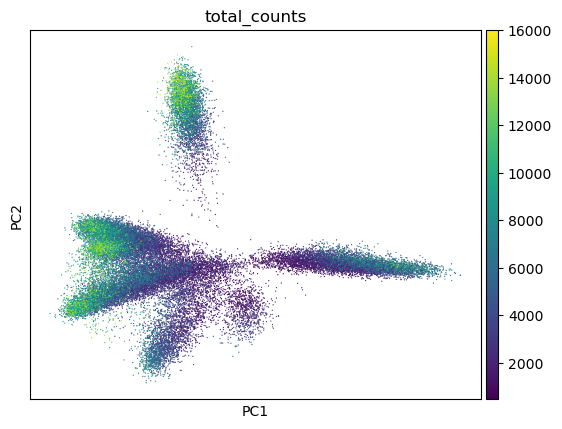

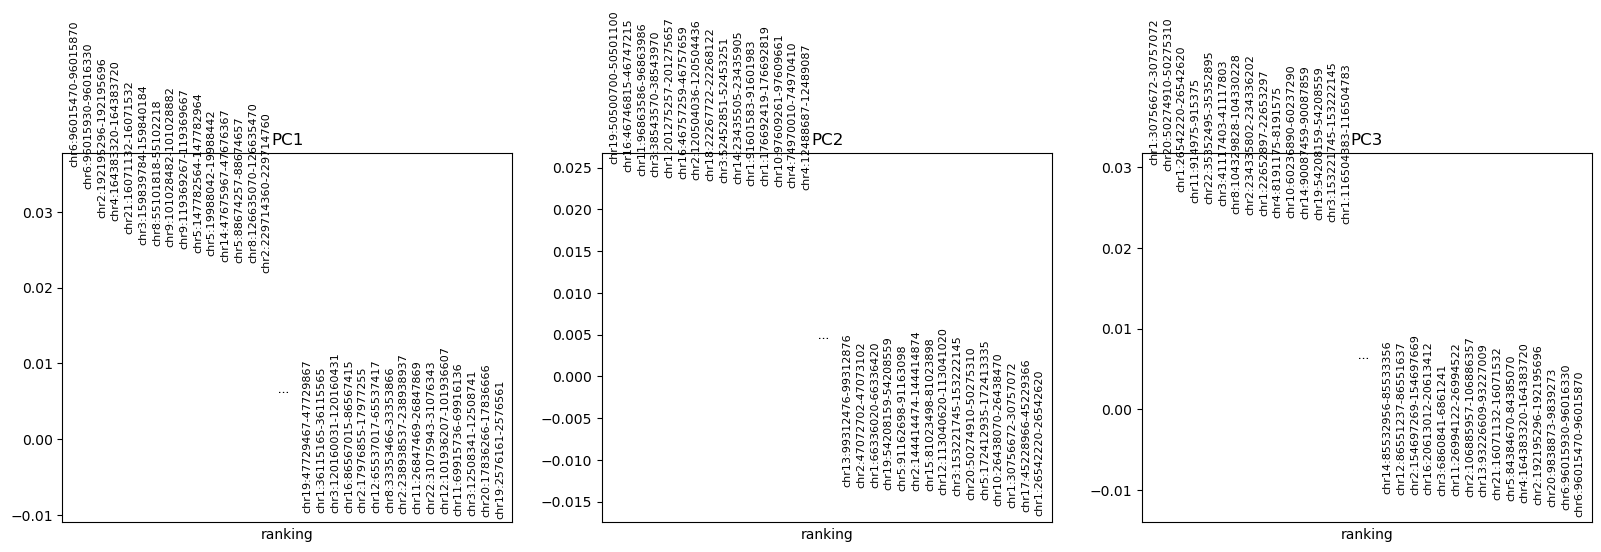

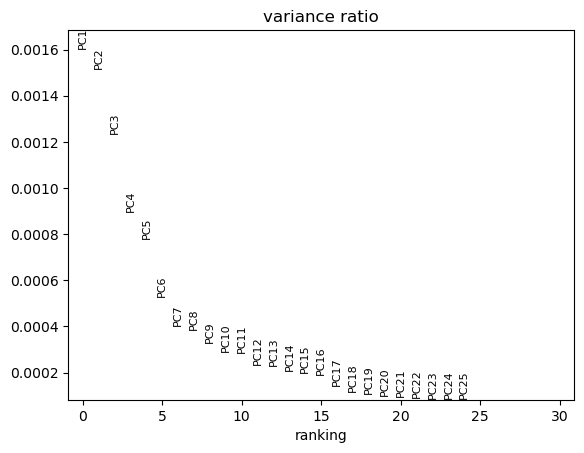

In [29]:
sc.pl.pca_overview(adata, color="total_counts")

In [30]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, method='umap', metric='euclidean')

CPU times: user 38.2 s, sys: 2.3 s, total: 40.5 s
Wall time: 35.9 s


In [31]:
%%time
sc.tl.umap(adata, min_dist=0.1, spread=2.5)

CPU times: user 35.2 s, sys: 6.93 s, total: 42.1 s
Wall time: 29.6 s


<Axes: title={'center': 'log1p_n_genes_by_counts'}, xlabel='UMAP1', ylabel='UMAP2'>

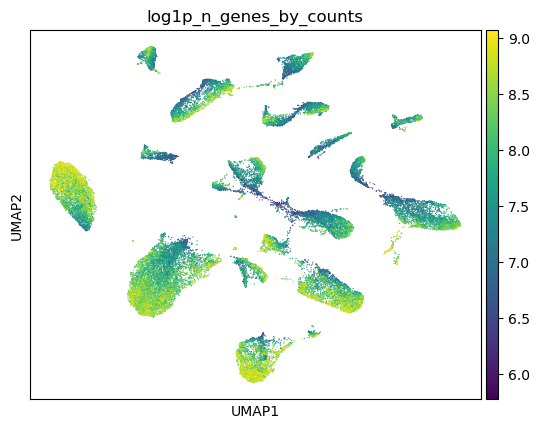

In [32]:
sc.pl.embedding(adata, basis='umap', ncols=3, show=False, color="log1p_n_genes_by_counts")

In [33]:
%%time
if "clusters" not in adata.uns:
    adata.uns["clusters"] = dict()

params = [
    ["lovain", 0.1],
    ["lovain", 0.25],
    ["lovain", 0.5],
    ["lovain", 1],
    ["leiden", 0.1],
    ["leiden", 0.25],
    ["leiden", 0.5],
    ["leiden", 1],
    ["kmeans", 13],
    ["kmeans", 16]
]
for method, value in params:
    tag = f'{method}_{value}'
    
    if method == 'lovain':
        sc.tl.louvain(adata, resolution=value, key_added=tag)
    elif method == 'leiden':
        sc.tl.leiden(adata, resolution=value, key_added=tag)
    elif method == 'kmeans':
        epi.tl.kmeans(adata, num_clusters=value)
        adata.obs[tag] = adata.obs["kmeans"]
        del adata.obs["kmeans"]
        adata.obs[tag] = adata.obs[tag].astype(str)
        adata.obs[tag] = adata.obs[tag].astype('category')
    else:
        print("unknown method: {method}")
    # calculate scores
    ari = epi.tl.ARI(adata, tag, 'ontology label')
    ami = epi.tl.AMI(adata, tag, 'ontology label')
    print(f"Method: {method}")
    print(f"value: {value}")
    print(f"ARI: {ari}")
    print(f"AMI: {ami}")

    
    adata.uns["clusters"][tag] = {
        "method": method,
        "param": {
           "n_clusters" if method == "kmeans" else "resoltution": value 
        },
        "score": {
            "ari": ari,
            "ami": ami
        }
    }

Method: lovain
value: 0.1
ARI: 0.8746871556813142
AMI: 0.901125841429616
Method: lovain
value: 0.25
ARI: 0.9386100623291695
AMI: 0.9297489918358597
Method: lovain
value: 0.5
ARI: 0.9210802385419525
AMI: 0.9214051552025747
Method: lovain
value: 1
ARI: 0.7873838452878035
AMI: 0.8913961566949951
Method: leiden
value: 0.1
ARI: 0.8990152890688285
AMI: 0.9149623663853131
Method: leiden
value: 0.25
ARI: 0.9451210465423201
AMI: 0.9344512248623257
Method: leiden
value: 0.5
ARI: 0.9112278560269448
AMI: 0.9185403701535664
Method: leiden
value: 1
ARI: 0.725314591415404
AMI: 0.8728998071483354


Method: kmeans
value: 13
ARI: 0.7941090655814373
AMI: 0.8496623276908045


Method: kmeans
value: 16
ARI: 0.8351115328992436
AMI: 0.8578385907351358
CPU times: user 48.5 s, sys: 8.23 s, total: 56.8 s
Wall time: 42.4 s


In [34]:
adata.uns["clusters"]

{'lovain_0.1': {'method': 'lovain',
  'param': {'resoltution': 0.1},
  'score': {'ari': 0.8746871556813142, 'ami': 0.901125841429616}},
 'lovain_0.25': {'method': 'lovain',
  'param': {'resoltution': 0.25},
  'score': {'ari': 0.9386100623291695, 'ami': 0.9297489918358597}},
 'lovain_0.5': {'method': 'lovain',
  'param': {'resoltution': 0.5},
  'score': {'ari': 0.9210802385419525, 'ami': 0.9214051552025747}},
 'lovain_1': {'method': 'lovain',
  'param': {'resoltution': 1},
  'score': {'ari': 0.7873838452878035, 'ami': 0.8913961566949951}},
 'leiden_0.1': {'method': 'leiden',
  'param': {'resoltution': 0.1},
  'score': {'ari': 0.8990152890688285, 'ami': 0.9149623663853131}},
 'leiden_0.25': {'method': 'leiden',
  'param': {'resoltution': 0.25},
  'score': {'ari': 0.9451210465423201, 'ami': 0.9344512248623257}},
 'leiden_0.5': {'method': 'leiden',
  'param': {'resoltution': 0.5},
  'score': {'ari': 0.9112278560269448, 'ami': 0.9185403701535664}},
 'leiden_1': {'method': 'leiden',
  'param

In [35]:
# calculate best cluster:
best_tag, best_ari = None, 0
for tag in adata.uns["clusters"]:
    ari = adata.uns["clusters"][tag]["score"]["ari"]
    if ari > best_ari:
        best_tag = tag
        best_ari = ari
print(best_tag, best_ari)
adata.uns["best_cluster"] = best_tag

leiden_0.25 0.9451210465423201


<Axes: title={'center': 'leiden_0.25'}, xlabel='UMAP1', ylabel='UMAP2'>

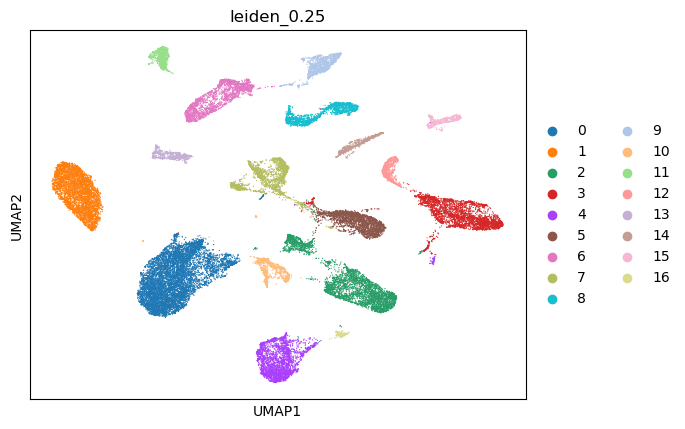

In [36]:
sc.pl.embedding(adata, basis='umap', ncols=3, show=False, color=adata.uns["best_cluster"])

<Axes: title={'center': 'ontology label'}, xlabel='UMAP1', ylabel='UMAP2'>

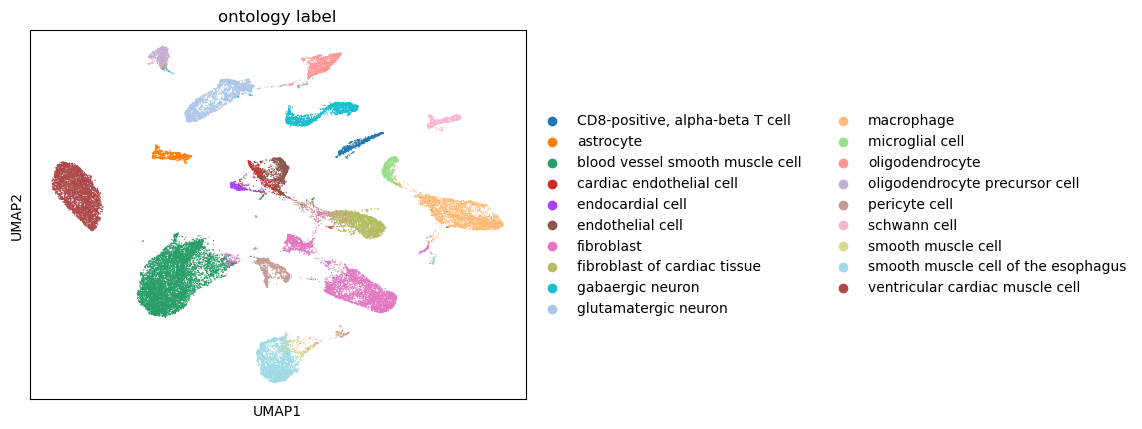

In [37]:
sc.pl.embedding(adata, basis='umap', ncols=3, show=False, color="ontology label")

__Rekey adata.var to genes__

In [38]:
# remove unannotated regions
adata = adata[:, ~adata.var['gene_name'].isna()]

In [39]:
duplicated_genes = adata.var['gene_name'][adata.var['gene_name'].duplicated(keep=False)]

In [40]:
%%time
adata_csc = adata.X.tocsc()

CPU times: user 692 ms, sys: 159 ms, total: 851 ms
Wall time: 850 ms


In [41]:
%%time
merged_data_dict = {}
for gene in duplicated_genes.unique():
    cols = np.where(adata.var['gene_name'] == gene)[0]
    data_slice = adata_csc[:, cols]
    merged = data_slice.max(axis=1)
    merged_data_dict[gene] = merged

CPU times: user 13.6 s, sys: 125 ms, total: 13.7 s
Wall time: 13.7 s


In [42]:
%%time
non_duplicated_genes = adata.var['gene_name'][~adata.var['gene_name'].duplicated(keep=False)]
for gene in non_duplicated_genes:
    cols = np.where(adata.var['gene_name'] == gene)[0]
    data_slice = adata_csc[:, cols]
    merged_data_dict[gene] = data_slice

CPU times: user 2.9 s, sys: 52.6 ms, total: 2.95 s
Wall time: 2.95 s


In [43]:
merged_matrix = hstack([l for l in merged_data_dict.values()], format='csr')

In [44]:
adata_merged = ad.AnnData(X=merged_matrix, obs=adata.obs, obsm=adata.obsm, var=pd.DataFrame(index=merged_data_dict.keys()))
adata_merged.uns.update(adata.uns)

In [45]:
%%time
adata_merged.write(
        out_file,
        compression="gzip")

CPU times: user 3.64 s, sys: 42.5 ms, total: 3.68 s
Wall time: 3.71 s


In [46]:
adata_merged

AnnData object with n_obs × n_vars = 37135 × 26532
    obs: 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'cell type', 'ontology label', 'ontology id', 'nb_features', 'log_nb_features', 'lovain_0.1', 'lovain_0.25', 'lovain_0.5', 'lovain_1', 'leiden_0.1', 'leiden_0.25', 'leiden_0.5', 'leiden_1', 'kmeans_13', 'kmeans_16'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'clusters', 'louvain', 'leiden', 'best_cluster', 'leiden_0.25_colors', 'ontology label_colors'
    obsm: 'X_pca', 'X_umap'

In [56]:
adata.uns["clusters"]


{'lovain_0.1': {'method': 'lovain',
  'param': {'resoltution': 0.1},
  'score': {'ari': 0.8746871556813142, 'ami': 0.901125841429616}},
 'lovain_0.25': {'method': 'lovain',
  'param': {'resoltution': 0.25},
  'score': {'ari': 0.9386100623291695, 'ami': 0.9297489918358597}},
 'lovain_0.5': {'method': 'lovain',
  'param': {'resoltution': 0.5},
  'score': {'ari': 0.9210802385419525, 'ami': 0.9214051552025747}},
 'lovain_1': {'method': 'lovain',
  'param': {'resoltution': 1},
  'score': {'ari': 0.7873838452878035, 'ami': 0.8913961566949951}},
 'leiden_0.1': {'method': 'leiden',
  'param': {'resoltution': 0.1},
  'score': {'ari': 0.8990152890688285, 'ami': 0.9149623663853131}},
 'leiden_0.25': {'method': 'leiden',
  'param': {'resoltution': 0.25},
  'score': {'ari': 0.9451210465423201, 'ami': 0.9344512248623257}},
 'leiden_0.5': {'method': 'leiden',
  'param': {'resoltution': 0.5},
  'score': {'ari': 0.9112278560269448, 'ami': 0.9185403701535664}},
 'leiden_1': {'method': 'leiden',
  'param